# Simple Content-based Recommenders #

**By Li-Yen Hsu**
<br>
<br>
**Hi all. I've been playing with this dataset for a few days and I would like to share my thoughts & codes here. Please feel free to leave any comment below. And hopefully there will be more discussions for this dataset :)**
<br>
**Updates on 10/30/2017: added another evaluation metric, Fraction of Concordant Pairs (FCP) and included a [SVD model](http://sifter.org/simon/journal/20061211.html) using [Surprise](http://surpriselib.com/).**
<br>
<br>
This work is largely inspired by the Recommender Systems section in [Andrew Ng's ML course](https://www.coursera.org/learn/machine-learning) (course notes: http://www.holehouse.org/mlclass/).
<br>
<br>
Our goal here is to predict the ratings that would be given by each consumer for the restaurants he/she has not rated. A list of restaurants with the highest predicted ratings can then be recommended to each consumer. Because the restaurant ratings are numerical, predicting their values can be treated as a regression problem. Using classification techniques is also reasonable since the possible ratings are three discrete integers in this dataset. However, a three-class classification will likely predict too many ties and therefore prevent us from generating a top-n list of recommendations for a consumer. Rather than predicting the exact values of ratings that a consumer would give to certain restaurants, what is more important is predicting the ranks of these restaurants for the consumer. Thus, I will attempt to predict continuous values for the consumer ratings.
<br>
<br>
I will use linear models to predict the ratings. The fundamental concepts are that each restaurant is characterized by a vector of features; each consumer preference is described by a vector of weights which has the same dimension as the product features; and the predicted rating of a restaurant-consumer pair equals the inner product of the two vectors. The mathematics is therefore equivalent to a simple linear regression. For a content-based approach, the features are already determined based on the product information, leaving the weights to be optimized. Instead of using an existing library for recommender systems, I will implement the cost functions of the problem and perform optimization using "minimize()" from the SciPy package. But I will also run a [SVD algorithm](http://sifter.org/simon/journal/20061211.html) using [Surprise](http://surpriselib.com/) (which is a collaborative filtering approach) at the end and compare its performance with mine.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

# Note that there are no NANs in these data; '?' is
# used when there is missing information
accepts = pd.read_csv('../input/chefmozaccepts.csv')
cuisine = pd.read_csv('../input/chefmozcuisine.csv')
hours = pd.read_csv('../input/chefmozhours4.csv')
parking = pd.read_csv('../input/chefmozparking.csv')
geo = pd.read_csv('../input/geoplaces2.csv') 
usercuisine = pd.read_csv('../input/usercuisine.csv')
payment = pd.read_csv('../input/userpayment.csv')
profile = pd.read_csv('../input/userprofile.csv')
rating = pd.read_csv('../input/rating_final.csv')

## Data Preprocessing ##
Let's first inspect each of these data frames

In [2]:
accepts.head()

,placeID,Rpayment
0,135110,cash
1,135110,VISA
2,135110,MasterCard-Eurocard
3,135110,American_Express
4,135110,bank_debit_cards


In [3]:
print("There are {} unique placeID's.".format(len(accepts.placeID.unique())))
print("There are {} unique Rpayment categories:".format(len(accepts.Rpayment.unique())))
print(accepts.Rpayment.unique())

There are 615 unique placeID's.
There are 12 unique Rpayment categories:
['cash' 'VISA' 'MasterCard-Eurocard' 'American_Express' 'bank_debit_cards'
 'checks' 'Discover' 'Carte_Blanche' 'Diners_Club' 'Visa'
 'Japan_Credit_Bureau' 'gift_certificates']


In [4]:
cuisine.head()

,placeID,Rcuisine
0,135110,Spanish
1,135109,Italian
2,135107,Latin_American
3,135106,Mexican
4,135105,Fast_Food


In [5]:
print("There are {} unique placeID's.".format(len(cuisine.placeID.unique())))
print("There are {} unique Rcuisine categories:".format(len(cuisine.Rcuisine.unique())))
print(cuisine.Rcuisine.unique())

There are 769 unique placeID's.
There are 59 unique Rcuisine categories:
['Spanish' 'Italian' 'Latin_American' 'Mexican' 'Fast_Food' 'Burgers'
 'Dessert-Ice_Cream' 'Hot_Dogs' 'Steaks' 'Asian' 'International'
 'Mongolian' 'Vegetarian' 'Brazilian' 'Cafe-Coffee_Shop' 'Cafeteria'
 'Contemporary' 'Deli-Sandwiches' 'Diner' 'Japanese' 'Sushi' 'Seafood'
 'Chinese' 'Bar' 'Bar_Pub_Brewery' 'Pizzeria' 'Mediterranean' 'American'
 'Family' 'Caribbean' 'African' 'Breakfast-Brunch' 'Regional' 'Afghan'
 'Bakery' 'Game' 'Armenian' 'Vietnamese' 'Korean' 'Thai' 'Barbecue'
 'Polish' 'Dutch-Belgian' 'French' 'German' 'Southwestern' 'Persian'
 'Ethiopian' 'Juice' 'Soup' 'Continental-European' 'Greek' 'Southern'
 'Eastern_European' 'California' 'Bagels' 'Turkish' 'Organic-Healthy'
 'Fine_Dining']


In [6]:
hours.head()

,placeID,hours,days
0,135111,00:00-23:30;,Mon;Tue;Wed;Thu;Fri;
1,135111,00:00-23:30;,Sat;
2,135111,00:00-23:30;,Sun;
3,135110,08:00-19:00;,Mon;Tue;Wed;Thu;Fri;
4,135110,00:00-00:00;,Sat;


In [7]:
print("There are {} unique placeID's.".format(len(hours.placeID.unique())))

There are 694 unique placeID's.


In [8]:
parking.head()

,placeID,parking_lot
0,135111,public
1,135110,none
2,135109,none
3,135108,none
4,135107,none


In [9]:
print("There are {} unique placeID's.".format(len(parking.placeID.unique())))
print("There are {} unique parking_lot categories:".format(len(parking.parking_lot.unique())))
print(parking.parking_lot.unique())

There are 675 unique placeID's.
There are 7 unique parking_lot categories:
['public' 'none' 'yes' 'valet parking' 'fee' 'street' 'validated parking']


In [10]:
geo.head()

,placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,...,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services
0,134999,18.915421,-99.184871,0101000020957F000088568DE356715AC138C0A525FC46...,Kiku Cuernavaca,Revolucion,Cuernavaca,Morelos,Mexico,?,...,No_Alcohol_Served,none,informal,no_accessibility,medium,kikucuernavaca.com.mx,familiar,f,closed,none
1,132825,22.147392,-100.983092,0101000020957F00001AD016568C4858C1243261274BA5...,puesto de tacos,esquina santos degollado y leon guzman,s.l.p.,s.l.p.,mexico,?,...,No_Alcohol_Served,none,informal,completely,low,?,familiar,f,open,none
2,135106,22.149709,-100.976093,0101000020957F0000649D6F21634858C119AE9BF528A3...,El Rinc�n de San Francisco,Universidad 169,San Luis Potosi,San Luis Potosi,Mexico,?,...,Wine-Beer,only at bar,informal,partially,medium,?,familiar,f,open,none
3,132667,23.752697,-99.163359,0101000020957F00005D67BCDDED8157C1222A2DC8D84D...,little pizza Emilio Portes Gil,calle emilio portes gil,victoria,tamaulipas,?,?,...,No_Alcohol_Served,none,informal,completely,low,?,familiar,t,closed,none
4,132613,23.752903,-99.165076,0101000020957F00008EBA2D06DC8157C194E03B7B504E...,carnitas_mata,lic. Emilio portes gil,victoria,Tamaulipas,Mexico,?,...,No_Alcohol_Served,permitted,informal,completely,medium,?,familiar,t,closed,none


In [11]:
print("There are {} unique placeID's.".format(len(geo.placeID.unique())))

There are 130 unique placeID's.


In [12]:
usercuisine.head()

,userID,Rcuisine
0,U1001,American
1,U1002,Mexican
2,U1003,Mexican
3,U1004,Bakery
4,U1004,Breakfast-Brunch


In [13]:
print("There are {} unique userID's.".format(len(usercuisine.userID.unique())))
print("There are {} unique Rcuisine categories:".format(len(usercuisine.Rcuisine.unique())))
print(usercuisine.Rcuisine.unique())

There are 138 unique userID's.
There are 103 unique Rcuisine categories:
['American' 'Mexican' 'Bakery' 'Breakfast-Brunch' 'Japanese' 'Contemporary'
 'Bagels' 'Cafe-Coffee_Shop' 'Continental-European' 'Cafeteria' 'Family'
 'Juice' 'Hawaiian' 'Hot_Dogs' 'Latin_American' 'Korean' 'Italian' 'Diner'
 'Fast_Food' 'Deli-Sandwiches' 'Regional' 'Fusion' 'Portuguese'
 'Indian-Pakistani' 'Eastern_European' 'Lebanese' 'Moroccan' 'Barbecue'
 'Polynesian' 'Polish' 'Chinese' 'Pizzeria' 'Burgers' 'Afghan'
 'Middle_Eastern' 'Mongolian' 'Bar' 'Cuban' 'Tex-Mex' 'Spanish' 'Soup'
 'Sushi' 'Game' 'Doughnuts' 'Australian' 'Asian' 'Dessert-Ice_Cream'
 'Seafood' 'Turkish' 'Organic-Healthy' 'Steaks' 'Mediterranean' 'British'
 'Austrian' 'Israeli' 'Russian-Ukrainian' 'Malaysian' 'Vegetarian'
 'Peruvian' 'Tapas' 'Eclectic' 'African' 'Basque' 'Canadian' 'Irish'
 'Southwestern' 'Tea_House' 'International' 'Pacific_Northwest' 'German'
 'Persian' 'Ethiopian' 'Romanian' 'Cambodian' 'Pacific_Rim' 'Tunisian'
 'Filipino

In [14]:
payment.head()

,userID,Upayment
0,U1001,cash
1,U1002,cash
2,U1003,cash
3,U1004,cash
4,U1004,bank_debit_cards


In [15]:
print("There are {} unique userID's.".format(len(payment.userID.unique())))
print("There are {} unique Upayment categories:".format(len(payment.Upayment.unique())))
print(payment.Upayment.unique())

There are 133 unique userID's.
There are 5 unique Upayment categories:
['cash' 'bank_debit_cards' 'MasterCard-Eurocard' 'VISA' 'American_Express']


In [16]:
profile.head()

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,none,student,black,69,medium,1.77
1,U1002,22.150087,-100.983325,false,abstemious,informal,family,public,single,independent,1990,technology,hunter-ostentatious,Catholic,student,red,40,low,1.87
2,U1003,22.119847,-100.946527,false,social drinker,formal,family,public,single,independent,1989,none,hard-worker,Catholic,student,blue,60,low,1.69
3,U1004,18.867000,-99.183000,false,abstemious,informal,family,public,single,independent,1940,variety,hard-worker,none,professional,green,44,medium,1.53
4,U1005,22.183477,-100.959891,false,abstemious,no preference,family,public,single,independent,1992,none,thrifty-protector,Catholic,student,black,65,medium,1.69


In [17]:
print("There are {} unique userID's.".format(len(profile.userID.unique())))

There are 138 unique userID's.


In [18]:
rating.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [19]:
print("There are {} unique userID's.".format(len(rating.userID.unique())))
print("There are {} unique placeID's.".format(len(rating.placeID.unique())))
print("There are {} * 3 ratings.".format(len(rating)))

There are 138 unique userID's.
There are 130 unique placeID's.
There are 1161 * 3 ratings.


In [20]:
rating.iloc[:,2:].describe()

,rating,food_rating,service_rating
count,1161.000000,1161.000000,1161.000000
mean,1.199828,1.215332,1.090439
std,0.773282,0.792294,0.790844
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000


Now let's see how many restaurants and users in total

In [21]:
res_all = np.concatenate((accepts.placeID.unique(), cuisine.placeID.unique(), 
                          hours.placeID.unique(), parking.placeID.unique(), geo.placeID.unique()))
res_all = np.sort( np.unique(res_all) ) # All the placeID's

print("There are {} restaurants.".format(len(res_all)))

There are 938 restaurants.


In [22]:
user_all = np.concatenate((usercuisine.userID.unique(), payment.userID.unique(), 
                           profile.userID.unique()))
user_all = np.sort( np.unique(user_all) ) # All the userID's

print("There are {} users.".format(len(user_all)))

There are 138 users.


Only 130 out of 938 restaurants have ratings. I will later work on these 130 only because it's not wise to recommend a restaurant without ratings. I will now create three data frames for the three types of rating, each of which will have a shape of (938, 138). A restaurant-user pair without a rating will be recorded as -1 (to be different from 0, the lowest rating).

In [23]:
overall_rating = pd.DataFrame( np.zeros((len(res_all),len(user_all)))-1.0, 
                              columns=user_all, index=res_all )
food_rating = overall_rating.copy()
service_rating = overall_rating.copy() 

for r, u, o, f, s in zip(rating.placeID, rating.userID, rating.rating, rating.food_rating, 
                         rating.service_rating):
    overall_rating.loc[r,u] = o
    food_rating.loc[r,u] = f
    service_rating.loc[r,u] = s

The following data frame tells us whether a restaurant-user pair has a rating. 0 means No and 1 means Yes.

In [24]:
review = pd.DataFrame( np.zeros(overall_rating.shape), columns=user_all, index=res_all)
review[overall_rating >= 0] = 1

Now I will combine the information of the restaurants and create a data frame for their features. I will skip "accepts" and "hours" for now because they shouldn't be revelant for modeling. However, their information will be required when recommendations are made.

In [25]:
# use dummy variables for different cuisine categories of the restaurants
res_cuisine = pd.get_dummies(cuisine,columns=['Rcuisine'])

# remove duplicate restaurant ID's. 
# A restaurant with multiple cuisine categories would have multiple columns equal 1
res_cuisine = res_cuisine.groupby('placeID',as_index=False).sum()

res_cuisine.head()

,placeID,Rcuisine_Afghan,Rcuisine_African,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Asian,Rcuisine_Bagels,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,...,Rcuisine_Soup,Rcuisine_Southern,Rcuisine_Southwestern,Rcuisine_Spanish,Rcuisine_Steaks,Rcuisine_Sushi,Rcuisine_Thai,Rcuisine_Turkish,Rcuisine_Vegetarian,Rcuisine_Vietnamese
0,132001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,132002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,132003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,132004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,132005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For a person who has a car, whether the restaurant has parking is relevant and may influence what rating he/she gives. Here I group the original parking options into only three categories (from best to worse): restaurant's free parking lot (2 points), other types of parking (1 point), and no parking (0 point)

In [26]:
parking.parking_lot.value_counts()

none                 348
yes                  174
public               102
street                32
fee                   22
valet parking         21
validated parking      3
Name: parking_lot, dtype: int64

In [27]:
res_parking = parking.copy()
res_parking.parking_lot = res_parking.parking_lot.map({'fee':1, 'none':0, 'public':1, 'yes':2,
                                        'street':1, 'valet parking':1, 'validated parking':1})

# remove duplicate restaurant ID's. 
# A restaurant with multiple parking options may have a value > 2
res_parking = res_parking.groupby('placeID',as_index=False).sum()

In the data frame "geo", some of the columns might be useful for rating prediction, while some are just names, locations, or websites. Locations are useful when recommendations are made, so I store them in a data frame "res_info". 

In [28]:
res_info = geo[['latitude','longitude','placeID','name','address','city','state']]

# These features should be relevant for rating prediction since they are about services 
# and price. Especially, 'alcohol','smoking_area', and 'price' relate to 'drink_level', 
# 'smoker', and 'budget' in the user profiles 
res_service_price = geo[['placeID','alcohol','smoking_area','other_services','price']]
print(res_service_price.alcohol.value_counts())
print('\n')
print(res_service_price.smoking_area.value_counts())
print('\n')
print(res_service_price.other_services.value_counts())
print('\n')
print(res_service_price.price.value_counts())

No_Alcohol_Served    87
Wine-Beer            34
Full_Bar              9
Name: alcohol, dtype: int64


none             70
not permitted    25
section          24
permitted         9
only at bar       2
Name: smoking_area, dtype: int64


none        119
variety       7
Internet      4
Name: other_services, dtype: int64


medium    60
low       45
high      25
Name: price, dtype: int64


In [29]:
# 1 if alcohol is available, 0 otherwise
res_service_price.alcohol = res_service_price.alcohol.map(lambda x: 0 if x == 'No_Alcohol_Served' else 1)
# 1 if there is smoking area, 0 otherwise
res_service_price.smoking_area = res_service_price.smoking_area.map(lambda x: 0 if (x == 'none') | (x == 'not permitted') else 1)
# 1 if other services are available, 0 otherwise
res_service_price.other_services = res_service_price.other_services.map(lambda x: 0 if x == 'none'  else 1)
# map price levels to numbers
res_service_price.price = res_service_price.price.map({'low': 1, 'medium': 2, 'high': 3})

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [30]:
# Whether these features are relevant is not so clear
res_environment = geo[['placeID','dress_code','accessibility','Rambience','area']]
print(res_environment.dress_code.value_counts())
print('\n')
print(res_environment.accessibility.value_counts())
print('\n')
print(res_environment.Rambience.value_counts())
print('\n')
print(res_environment.area.value_counts())

informal    118
casual       10
formal        2
Name: dress_code, dtype: int64


no_accessibility    76
completely          45
partially            9
Name: accessibility, dtype: int64


familiar    121
quiet         9
Name: Rambience, dtype: int64


closed    115
open       15
Name: area, dtype: int64


In [31]:
# 1 if formal dress is required, 0 otherwise
res_environment.dress_code = res_environment.dress_code.map({'informal':0, 'casual':0, 'formal': 1})
# map accessibility levels to numbers
res_environment.accessibility = res_environment.accessibility.map({'no_accessibility':0, 'partially':1, 'completely': 2})
res_environment.Rambience = res_environment.Rambience.map({'familiar':0, 'quiet': 1})
res_environment.area = res_environment.area.map({'open':0, 'closed':1})

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Now I will combine the restaurant information to one data frame

In [32]:
df_res = pd.DataFrame({'placeID': res_all})
df_res = pd.merge(left=df_res, right=res_cuisine, how="left", on="placeID")
df_res = pd.merge(left=df_res, right=res_parking, how="left", on="placeID")
df_res = pd.merge(left=df_res, right=res_service_price, how="left", on="placeID")
df_res = pd.merge(left=df_res, right=res_environment, how="left", on="placeID")

print(df_res.shape)
df_res.head()

(938, 69)


,placeID,Rcuisine_Afghan,Rcuisine_African,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Asian,Rcuisine_Bagels,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,...,Rcuisine_Vietnamese,parking_lot,alcohol,smoking_area,other_services,price,dress_code,accessibility,Rambience,area
0,132001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,132002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,132003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,132004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,132005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# The placeID's for the 130 restaurants with ratings
res_rated = res_all[np.sum(review,axis=1) > 0] 

# tells us whether a restaurant-user pair has a rating. 0 means No and 1 means Yes.
R = review.loc[res_rated].values  # shape = (130,138)

Y_service = service_rating.loc[res_rated].values
Y_overall = overall_rating.loc[res_rated].values
Y_food  = food_rating.loc[res_rated].values

In [34]:
# select the indices of "df_res" where a restaurant has ratings
index = np.array([x in res_rated for x in df_res['placeID'].values])
index = np.where(index == True)[0]
# restaurant features for the 130 restaurants with ratings
X = df_res.loc[index, :].reset_index(drop=True)
print(X.isnull().sum()) # all the NANs are from cuisine 

placeID                           0
Rcuisine_Afghan                  35
Rcuisine_African                 35
Rcuisine_American                35
Rcuisine_Armenian                35
Rcuisine_Asian                   35
Rcuisine_Bagels                  35
Rcuisine_Bakery                  35
Rcuisine_Bar                     35
Rcuisine_Bar_Pub_Brewery         35
Rcuisine_Barbecue                35
Rcuisine_Brazilian               35
Rcuisine_Breakfast-Brunch        35
Rcuisine_Burgers                 35
Rcuisine_Cafe-Coffee_Shop        35
Rcuisine_Cafeteria               35
Rcuisine_California              35
Rcuisine_Caribbean               35
Rcuisine_Chinese                 35
Rcuisine_Contemporary            35
Rcuisine_Continental-European    35
Rcuisine_Deli-Sandwiches         35
Rcuisine_Dessert-Ice_Cream       35
Rcuisine_Diner                   35
Rcuisine_Dutch-Belgian           35
Rcuisine_Eastern_European        35
Rcuisine_Ethiopian               35
Rcuisine_Family             

In [35]:
X = X.fillna(0) # fill all NANs with 0
# drop a feature if the entire column are 0
features_to_drop = X.columns.values[np.sum(X,axis=0) == 0] 
X = X.drop(features_to_drop, axis=1)
X = X.drop(['placeID'], axis=1)
X.head()

,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,Rcuisine_Breakfast-Brunch,Rcuisine_Burgers,Rcuisine_Cafe-Coffee_Shop,Rcuisine_Cafeteria,Rcuisine_Chinese,...,Rcuisine_Vietnamese,parking_lot,alcohol,smoking_area,other_services,price,dress_code,accessibility,Rambience,area
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


Now we have 32 features for each of the restaurants. Removing irrelevant features can not only avoid overfitting, but also reduce dimensionality and therefore the computation time. One thing I tried was to compute the average ratings of the 138 restaurants, and then inspect the correlation coefficients between the features and average ratings. This can rank the importance of individual features and allows us to remove those with low correlation coefficients. However, at the end of the day I found that the performance of my model changes very little as I changes the number of features. This is probably because the ratings just don't depend a lot on these features. The main factors that affect the ratings are (1) whether the food is delicious and (2) whether a customer had a satisfying experience about the service provided. These two are definitely not something that are in the data. 
<br>
<br>
In the following, I will only use 'parking_lot','alcohol','smoking_area','other_services','price','dress_code', and 'accessibility'. After some tests (which I skip here), I found the performance based on these 7 features is as good as a model that includes all the 32 features, and of course, this runs much faster.

In [36]:
X = X[['parking_lot','alcohol','smoking_area','other_services','price','dress_code','accessibility']]
X['x0'] = 1 # add a bias term for linear regressions
X.head()

,parking_lot,alcohol,smoking_area,other_services,price,dress_code,accessibility,x0
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1
2,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1
3,2.0,0.0,0.0,0.0,1.0,0.0,2.0,1
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1


I will try three models. The first one is a benchmark model which simply predicts the average of the ratings that a restaurant already received. Therefore, we can compare other models with this benchmark to see if we are doing better than just using average ratings. The second one is a content-based predictor which uses the restaurant features above ('X'). The third one is another content-based predictor that also takes some user information into account (details and user data processing will be shown later).
<br>
<br>
Before we implement the models, let's split the existing ratings into a training set and a validation set. I will use a 75/25 split. Note that what are being split are the rating instances, not the examples of restaurants or users. Rather than just randomly splitting the data, I will ensure that every restaurant and every consumer receives/gives some ratings in the training set. This constraint makes sure that the characteristic of every restaurant and consumer is learned.

In [37]:
num_rating = np.round(np.sum(R,axis=0)) # number of ratings from each user (minimum = 3)

# 25% of the existing ratings will be used as the validation set
# So during the training, they will be flagged 
g = lambda x: int(round(x*0.25)) 
flag = np.array( [g(x) for x in num_rating] )

random.seed(0)
cond = True

while cond:

    R_train = R.copy()

    # loop over each user
    for i in range(R_train.shape[1]):
        # the restaurants that are rated
        index = list( np.where(R_train[:,i] == 1)[0] )  
        # randomly select about 25% of them to be flagged
        index_flag = random.sample(index,flag[i])
        R_train[index_flag,i] = 0  
    
    # make sure in the traning set, each restaurant and each user receives/gives at least 
    # 2 ratings
    if (np.sum(R_train,axis=0).min() > 1) & (np.sum(R_train,axis=1).min() > 1): 
        cond = False
        
R_valid = R - R_train 
# Now "R_train" contains 876 ones, and "R_valid" contains 285 ones ("R" contains 1161 ones)
# The shape of "R", "R_train" and "R_valid" are all (130,138)  
print(R_train.sum())
print(R_valid.sum())

876.0
285.0


## Evaluation Metrics ##
I will use two evaluation metrics to quantify the model performances. The first one is root-mean-squre error (RMSE), which is very standard for regression problems because it tells you how close your predictions are to the labels. However, for recommender systems, the most important thing is the ranks of the products, and RMSE sometimes doesn't work will for this purpose. For example, a perfectly ranked prediction can have a terrible RMSE by predicting the ratings on the wrong scale.
<br>
<br>
Thus, the second metric I will use is **Fraction of Concordant Pairs (FCP)** Please refer to Section 5.2 of http://www.ijcai.org/Proceedings/13/Papers/449.pdf. The concept is the following. Suppose a user has rated n products, then there are n*(n-1)/2 unique pairs of ratings. If product A receives a higher rating than product B from a user and the model predicts the same, A and B are a concordant pair, otherwise a discordant pair. FCP is simply the fraction of concordant pairs among all the pairs (sum over all users). Note that because the ratings are discrete integers, many rating pairs would actually be ties. For such cases I will not include them in the calculation of FCP.

In [38]:
# FCP
def FCP(Y,Y_pred,R):
    
    # list of true ratings from each user (we only select users with at least two ratings)
    Y_fcp = []  
    Y_pred_fcp = [] # list of predicted ratings from each user 
    n_user = R.shape[1]
    
    for i in range(n_user):
        
        cond = (R.sum(axis=0) >= 2)[i] # there should be at least two ratings from a user
        index = np.where( R[:,i] == 1)[0] # the indices (restaurants) with ratings
    
        if cond:
            
            Y_fcp.append( (Y*R)[:,i][index] )
            Y_pred_fcp.append( (Y_pred*R)[:,i][index] )

        
    n_fcp = len(Y_fcp) # number of users with at least two ratings
    TP = 0. # Total number of pairs
    DP = 0. # number of discordant pairs
    CP = 0. # number of concordant pairs (excluding ties)
    
    for i in range(n_fcp):
        
        num_Y = len(Y_fcp[i])   # number of ratings from a user
        TP += num_Y*(num_Y-1)/2 # number of rating pairs = n*(n+1)/2 

        greater = np.array([])
        greater_pred = np.array([])

        # this loop is to go over all the rating pairs
        for j in range(num_Y-1):
            
            not_equal = Y_fcp[i][j] != Y_fcp[i][j+1:]
            greater = Y_fcp[i][j] > Y_fcp[i][j+1:]
            greater_pred = Y_pred_fcp[i][j] > Y_pred_fcp[i][j+1:]

            # filter the ones that are not ties
            greater = greater[not_equal]
            greater_pred = greater_pred[not_equal]

            DP += (greater != greater_pred).sum()
            CP += (greater == greater_pred).sum()
            
    print("Total number of rating pairs: {}".format(int(TP)))
    print("Total number of discordant pairs: {}".format(int(DP)))
    print("Total number of concordant pairs: {}".format(int(CP)))
    print("Total number of ties: {}".format(int(TP-DP-CP)))
    print("FCP: {}".format(CP/(CP+DP)))


Now we can try the three models. I will only predict the overall ratings here (otherwise this notebook would be too long...)

## Benchmark Model ##
This model just computes the average rating of each restaurant.

In [39]:
def GetMean(Y,R):

    Y = Y*R
    mean =  (np.sum(Y, axis=1)/np.sum((R == 1.0), axis=1)).reshape(Y.shape[0],1) * np.ones(Y.shape)
    return mean

In [40]:
Y = Y_overall 
Y_mean = GetMean(Y,R_train) # get the average ratings based on the training set
Y_pred = np.zeros(Y.shape) + Y_mean # prediction 

# RMSE
print("RMSE of the training set: {}".format(np.sqrt(mean_squared_error(Y[R_train == 1], Y_pred[R_train == 1]))))
print("RMSE of the validation set: {}".format(np.sqrt(mean_squared_error(Y[R_valid == 1], Y_pred[R_valid == 1]))))

RMSE of the training set: 0.6930171831949701
RMSE of the validation set: 0.828933960093509


In [41]:
# FCP
print("Training Set:")
FCP(Y,Y_pred,R_train)
print("\n")
print("Validation Set:")
FCP(Y,Y_pred,R_valid)

Training Set:
Total number of rating pairs: 2808
Total number of discordant pairs: 395
Total number of concordant pairs: 859
Total number of ties: 1554
FCP: 0.6850079744816587


Validation Set:
Total number of rating pairs: 201
Total number of discordant pairs: 32
Total number of concordant pairs: 39
Total number of ties: 130
FCP: 0.5492957746478874


In [42]:
def MakeBoxplot(Y_pred, Y_true, R, title):
    
    data1 = Y_pred[R == 1][Y_true[R == 1] == 0]
    data2 = Y_pred[R == 1][Y_true[R == 1] == 1]
    data3 = Y_pred[R == 1][Y_true[R == 1] == 2]
    data = [data1,data2,data3]

    fig = plt.figure()
    plt.boxplot(data)
    plt.xticks([1, 2, 3],[0,1,2])
    plt.xlabel('True Rating')
    plt.ylabel('Predicted Rating')
    plt.title(title)
    plt.show()

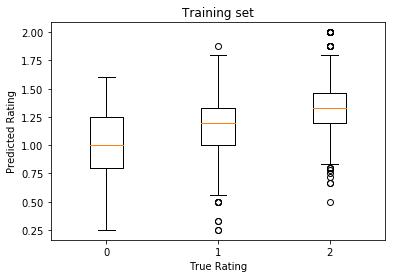

In [43]:
MakeBoxplot(Y_pred, Y, R_train, 'Training set')

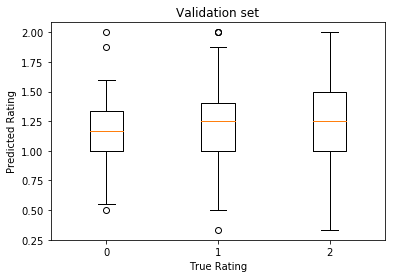

In [44]:
MakeBoxplot(Y_pred, Y, R_valid, 'Validation set')

## Content-Based Model 1##
Let's first implement the cost function and the gradient of its parameters using matrix factorization. For the mathematical detail, please refer to Andrew Ng's ML course: http://www.holehouse.org/mlclass/16_Recommender_Systems.html

In [45]:
# The parameters of the cost function are the weights of all the users, with a shape = 
# (n_user, n_feature), where n_user = 138 = number of users, and n_feature = 8 = number 
# of restaurant features (including the bias term). However, to feed the cost function 
# to SciPy's minimize(), the parameters of the function cannot be a matrix and has to be 
# a 1D vector

def CostFunction(params, X, Y, R, lambd): # lambd is the L2 regularization coefficient
    
    num_user = R.shape[1]
    num_feature = X.shape[1]

    # reshape the parameters to a 2D matrix so we can perform matrix factorization
    Theta = params.reshape(num_user, num_feature)
    J = 0.5 * np.sum( (np.dot(X, Theta.T) * R - Y)**2 )

    # regularization
    J = J + lambd/2. * np.sum(Theta[:,:-1]**2) 

    return J


def Gradient(params, X, Y, R, lambd):
    
    num_user = R.shape[1]
    num_feature = X.shape[1]

    Theta = params.reshape(num_user, num_feature)
    Theta_grad = np.dot((np.dot(Theta, X.T) * R.T - Y.T), X)

    # regularization
    Theta_grad[:,:-1] = Theta_grad[:,:-1] + lambd*Theta[:,:-1]

    return Theta_grad.reshape(-1)

Secondly, we need to perform "mean normalization" on the ratings. For each restaurant, we will subtract the average rating from all the ratings (in the training set). So after the normalization, the average rating is 0 for all the restaurant. The model will be trained on these normalized ratings instead of the original values. When we make the prediction, we will add those average ratings back.  
<br>
According to Andrew Ng's course, the reason for doing this is that if there is a user who never rated anything (so there is no data we can learn from this user), the predicted ratings for him/her will be the average values.
<br>
<br>
In our dataset, all the users have rated some restaurants. However, (I think) mean normalization is still required to account for the overall food & service quality of a restaurant, which is not in the data. As I mentioned earlier, the ratings just don't depend that much on the restaurant features because they are not the main factors. When mean normalization is performed, what the model learns and predicts is the **deviation** from the average rating (as a function of user preference) instead of the absolute value of a rating. The average rating of each restaurant is the best we can use as a proxy of the overall food & service quality. If mean normalization is not performed, the model would perform poorly.

In [46]:
def MeanNorm(Y,R):
    
    Y_norm = Y*R
    mean =  (np.sum(Y_norm, axis=1)/np.sum((R == 1.0), axis=1)).reshape(Y.shape[0],1) * np.ones(Y.shape)
    Y_norm = (Y_norm - mean)*R

    return Y_norm, mean

In [47]:
Y_norm, Y_mean = MeanNorm(Y,R_train)

n_user = R.shape[1]
n_feature = X.shape[1]
lambd = 64. # L2 regularization; I ran the optimization multiple times with different values 
            # (1, 2, 4, 8...) and 64 results in the best validation FCP
    
Theta = np.random.normal(0,1,(n_user, n_feature)).reshape(-1) # initialize the weights

result = minimize(CostFunction, Theta, jac=Gradient, args=(X, Y_norm, R_train, lambd),
                  options={'disp': True, 'maxiter': 500})

Optimization terminated successfully.
         Current function value: 109.024339
         Iterations: 202
         Function evaluations: 271
         Gradient evaluations: 271


In [48]:
Theta_opt = result.x.reshape(n_user, n_feature) # reshape the optimial parameters to a 2D matrix 
Y_pred = np.dot(X, Theta_opt.T) + Y_mean
print("RMSE of the training set: {}".format(np.sqrt(mean_squared_error(Y[R_train == 1], Y_pred[R_train == 1]))))
print("RMSE of the validation set: {}".format(np.sqrt(mean_squared_error(Y[R_valid == 1], Y_pred[R_valid == 1]))))

RMSE of the training set: 0.49150999311074817
RMSE of the validation set: 0.6992958977933318


In [49]:
print("Training Set:")
FCP(Y,Y_pred,R_train)
print("\n")
print("Validation Set:")
FCP(Y,Y_pred,R_valid)

Training Set:
Total number of rating pairs: 2808
Total number of discordant pairs: 356
Total number of concordant pairs: 898
Total number of ties: 1554
FCP: 0.7161084529505582


Validation Set:
Total number of rating pairs: 201
Total number of discordant pairs: 31
Total number of concordant pairs: 40
Total number of ties: 130
FCP: 0.5633802816901409


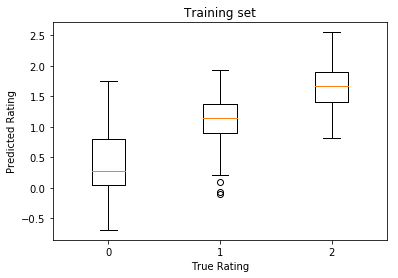

In [50]:
MakeBoxplot(Y_pred, Y, R_train, 'Training set')

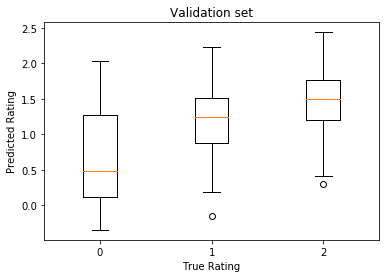

In [51]:
MakeBoxplot(Y_pred, Y, R_valid, 'Validation set')

The performance is better than the benchmark model.

## Content-Based Model 2##
For this model, I will take into account the user information that is related to some of the restaurant features, namely, 'smoker', 'drink_level', 'transport', 'budget'. Let's first process the user data.

In [52]:
user_info = profile[['smoker','drink_level','transport','budget']]

print(user_info.smoker.value_counts())
print('\n')
print(user_info.drink_level.value_counts())
print('\n')
print(user_info.transport.value_counts())
print('\n')
print(user_info.budget.value_counts())

false    109
true      26
?          3
Name: smoker, dtype: int64


abstemious        51
casual drinker    47
social drinker    40
Name: drink_level, dtype: int64


public       82
car owner    35
on foot      14
?             7
Name: transport, dtype: int64


medium    91
low       35
?          7
high       5
Name: budget, dtype: int64


In [53]:
# 1 for smokers, 0 otherwise; assume '?' to be non-smokers
user_info.smoker = user_info.smoker.map({'false': 0, 'true': 1, '?': 0})
# map drink levels to numbers
user_info.drink_level = user_info.drink_level.map({'abstemious': 1, 'casual drinker': 2, 'social drinker': 3})
# 1 for car owners, 0 otherwise; assume '?' to be not car owners
user_info.transport = user_info.transport.map({'public':0, 'car owner':1, 'on foot':0, '?':0})
# map budget levels to numbers; assume '?' to be medium
user_info.budget = user_info.budget.map({'medium':2, 'low':1, 'high':3, '?':2})

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [54]:
user_info.head()

,smoker,drink_level,transport,budget
0,0,1,0,2
1,0,1,0,1
2,0,3,0,1
3,0,1,0,2
4,0,1,0,2


Here I create a matrix, "Theta_modifier" with a shape = (n_user, n_feature), to **adjust the restaurant features the users see.** Most of the elements in this matrix are one, except for those corresponding to 'parking_lot', 'smoking_area', 'alcohol', and 'price':
<br>
(1) If a user doesn't have a car, he/she wouldn't care if there is parking and a corresponding weight for 'parking_lot' is not needed. <br>
(2) If a user doesn't smoke, he/she wouldn't care if there is a smoking area and a corresponding weight for 'smoking_area' is not needed. <br>
(3) Users with different 'drink_level' care differently about whether alcohol is provided in the restaurant.<br>
(4) Users with different 'budget' care differently about the price. People with higher budget cares less.

In [55]:
Theta_modifier = pd.DataFrame(np.ones((n_user, n_feature)), columns=X.columns.values) 
Theta_modifier['parking_lot'] = user_info['transport'] # 0 or 1
Theta_modifier['alcohol'] = user_info['drink_level'] # 1, 2 or 3
Theta_modifier['smoking_area'] = user_info['smoker'] # 0 or 1
Theta_modifier['price'] = 1.0/user_info['budget'] # 1 (low), 1/2 (medium) or 1/3 (high)
Theta_modifier = Theta_modifier.values

The parameters (weights) of the cost function correspond to those in "Theta_modifier" which has a value greater than 0

In [56]:
def CostFunction2(params, X, Y, R, Theta_modifier, lambd):

    num_user = R.shape[1]
    num_feature = X.shape[1]

    # reshape the Theta_modifier to 1-D
    Theta_temp = Theta_modifier.reshape(-1)
    # elements with non-zero values in Theta_modifier are multiplied to the input weights
    Theta_temp[Theta_temp > 0] = Theta_temp[Theta_temp > 0] * params
    
    # reshape the parameters to a 2D matrix so we can perform matrix factorization.
    # Elements with zero values in Theta_modifier always remain 0 in this matrix (for those 
    # users who don't have a car and those who don't smoke)
    Theta = Theta_temp.reshape(num_user, num_feature)
    J = 0.5 * np.sum( (np.dot(X, Theta.T) * R - Y)**2 )

    # regularization
    J = J + lambd/2. * np.sum(Theta[:,:-1]**2) 

    return J


def Gradient2(params, X, Y, R, Theta_modifier, lambd):

    num_user = R.shape[1]
    num_feature = X.shape[1]

    Theta_temp = Theta_modifier.reshape(-1)
    Theta_temp[Theta_temp > 0] = Theta_temp[Theta_temp > 0] * params

    Theta = Theta_temp.reshape(num_user, num_feature)
    Theta_grad = np.dot((np.dot(Theta, X.T) * R.T - Y.T), X) 

    # regularization
    Theta_grad[:,:-1] = Theta_grad[:,:-1] + lambd*Theta[:,:-1]
    Theta_grad = Theta_grad * Theta_modifier

    Theta_grad = Theta_grad[Theta_modifier > 0]
    
    return Theta_grad

In [57]:
lambd = 64. # L2 regularization; I ran the optimization multiple times with different values 
            # (1, 2, 4, 8...) and 64 results in the best validation FCP
    
Theta = np.random.normal(0,1,(n_user, n_feature))[Theta_modifier > 0] # initialize the weights

result = minimize(CostFunction2, Theta, jac=Gradient2, args=(X, Y_norm, R_train, Theta_modifier, 
                  lambd), options={'disp': True, 'maxiter': 500})

Optimization terminated successfully.
         Current function value: 110.032844
         Iterations: 231
         Function evaluations: 279
         Gradient evaluations: 279


In [58]:
# elements with non-zero values in Theta_modifier are multiplied to the optimal weights
Theta_transformer = Theta_modifier.reshape(-1)
Theta_transformer[Theta_transformer > 0] = Theta_transformer[Theta_transformer > 0] * result.x
# reshape the parameters to a 2D matrix 
Theta_opt = Theta_transformer.reshape(n_user, n_feature)

Y_pred = np.dot(X, Theta_opt.T) + Y_mean
print("RMSE of the training set: {}".format(np.sqrt(mean_squared_error(Y[R_train == 1], Y_pred[R_train == 1]))))
print("RMSE of the validation set: {}".format(np.sqrt(mean_squared_error(Y[R_valid == 1], Y_pred[R_valid == 1]))))

RMSE of the training set: 0.4959089377539185
RMSE of the validation set: 0.6986709074499278


In [59]:
print("Training Set:")
FCP(Y,Y_pred,R_train)
print("\n")
print("Validation Set:")
FCP(Y,Y_pred,R_valid)

Training Set:
Total number of rating pairs: 2808
Total number of discordant pairs: 362
Total number of concordant pairs: 892
Total number of ties: 1554
FCP: 0.7113237639553429


Validation Set:
Total number of rating pairs: 201
Total number of discordant pairs: 31
Total number of concordant pairs: 40
Total number of ties: 130
FCP: 0.5633802816901409


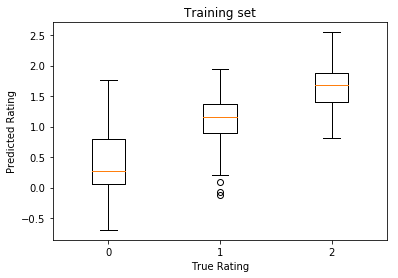

In [60]:
MakeBoxplot(Y_pred, Y, R_train, 'Training set')

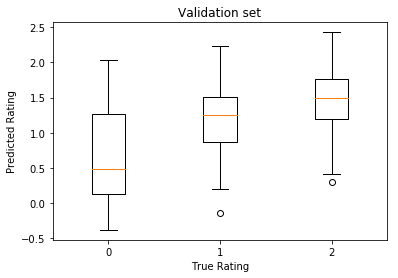

In [61]:
MakeBoxplot(Y_pred, Y, R_valid, 'Validation set')

Unfortunately this doesn't really improve the result. Also, the two models perform better than the benchmark model by only a little (in terms of FCP). Later let's try the Surprise package and see if it can do a better job.

In [62]:
R_test =  R*(-1) + 1.0 # 1 for those without existing ratings, 0 otherwise

# predicted ratings for the restaurants that each user hasn't visited
Y_final = Y_pred * R_test
Y_final = pd.DataFrame( Y_final, columns=user_all, index=res_rated )
Y_final.head()

,U1001,U1002,U1003,U1004,U1005,U1006,U1007,U1008,U1009,U1010,...,U1129,U1130,U1131,U1132,U1133,U1134,U1135,U1136,U1137,U1138
132560,0.163740,0.604283,0.456769,0.681650,0.354380,0.582535,0.042386,0.409461,0.709452,0.316296,...,0.241337,0.275990,0.497432,0.652353,0.372582,0.296975,-0.880664,0.547155,0.787210,0.834625
132561,0.545510,0.988817,0.811936,0.987383,0.686475,0.928679,0.406147,0.754006,1.017195,0.669804,...,0.000000,0.000000,0.837818,1.005382,0.644856,0.563836,-0.535511,0.911746,1.171390,1.167959
132564,1.128844,1.572150,1.395270,1.570717,1.269808,1.512013,0.989481,1.337339,1.600528,1.253138,...,1.172855,1.148102,1.421151,1.588715,1.228189,1.147169,0.047822,1.495079,1.754724,1.751292
132572,0.801921,1.245227,1.068347,1.243794,0.942885,0.000000,0.000000,1.010416,1.273605,0.885864,...,0.845932,0.821179,1.134477,1.261792,0.943213,0.000000,-0.279101,1.176240,1.427801,1.424369
132583,1.187958,1.629883,1.467686,1.667850,1.353761,1.588748,1.057600,1.415067,1.696657,1.336471,...,1.248762,1.253713,1.490896,1.662201,1.331566,1.263739,0.125245,1.566483,1.812633,1.834625


With the predicted ratings for the restaurants each user hasn't visited, we can recommend the top-n list for each user along with the restaurant information. To avoid recommending a restaurant that is too far away from the user, we can use a search radius to pre-select all the places that are within this range. These should all be straightforward, so I will just stop here.

## SVD with the Surprise Package##
Surprise is an easy-to-use Python package for recommender systems. Please refer to their [project page](http://surpriselib.com/) and [document page](http://surprise.readthedocs.io/en/stable/index.html#) for details of installation and tutorials. Here I will use the famous [SVD algorithm](http://sifter.org/simon/journal/20061211.html).

In [63]:
from surprise import SVD 
from surprise.dataset import Reader, Dataset

To load a data frame or csv file, the columns must correspond to user id, item id and ratings (in this order). In order to compare the result of SVD with my models, we have to use the same training/validation split that are used above and transform them to the form that can be fed to Surprise.

In [64]:
uID = []
pID = []
r = []

for i in range(R.shape[1]):
    for j in range(R.shape[0]):

        if R_train[j,i] == 1:
            
            pID.append(res_rated[j])
            uID.append(user_all[i])
            r.append(Y[j,i])


rating_train = pd.DataFrame({'userID':uID, 'placeID':pID, 'rating':r})
rating_train = rating_train[['userID','placeID','rating']]

uID = []
pID = []
r = []

for i in range(R.shape[1]):
    for j in range(R.shape[0]):

        if R_valid[j,i] == 1:
            
            pID.append(res_rated[j])
            uID.append(user_all[i])
            r.append(Y[j,i])


rating_valid = pd.DataFrame({'userID':uID, 'placeID':pID, 'rating':r})
rating_valid = rating_valid[['userID','placeID','rating']]

In [65]:
# A reader is needed to specify the rating_scale
reader = Reader(rating_scale=(0, 2))
data_train = Dataset.load_from_df(rating_train, reader)
trainset = data_train.build_full_trainset() # use the whole training set 

In [66]:
model = SVD() # better performance can be done by playing with the parameters
model.train(trainset)

# my data form of ratings: shape=(130,138)
Y_pred = pd.DataFrame( np.zeros((len(res_rated),len(user_all)))-1.0, columns=user_all, index=res_rated )

size_valid = len(rating_valid)
size_train = len(rating_train)
r_pred_valid = np.zeros(size_valid)
r_pred_train = np.zeros(size_train)

# obtain predictions for the validation set
for i in range(size_valid):
    pred = model.predict(rating_valid.userID[i], rating_valid.placeID[i], verbose=False)
    r_pred_valid[i] = pred.est

# fill the predictions into my 'Y_pred' data frame
for r, u, o in zip(rating_valid.placeID, rating_valid.userID, r_pred_valid):
    Y_pred.loc[r,u] = o

# obtain predictions for the training set    
for i in range(size_train):
    pred = model.predict(rating_train.userID[i], rating_train.placeID[i], verbose=False)
    r_pred_train[i] = pred.est

# fill the predictions into my 'Y_pred' data frame    
for r, u, o in zip(rating_train.placeID, rating_train.userID, r_pred_train):
    Y_pred.loc[r,u] = o
    
Y_pred = Y_pred.values    

In [67]:
print("RMSE of the training set: {}".format(np.sqrt(mean_squared_error(Y[R_train == 1], Y_pred[R_train == 1]))))
print("RMSE of the validation set: {}".format(np.sqrt(mean_squared_error(Y[R_valid == 1], Y_pred[R_valid == 1]))))

RMSE of the training set: 0.4779161431289391
RMSE of the validation set: 0.6869440621848735


In [68]:
print("Training Set:")
FCP(Y,Y_pred,R_train)
print("\n")
print("Validation Set:")
FCP(Y,Y_pred,R_valid)

Training Set:
Total number of rating pairs: 2808
Total number of discordant pairs: 93
Total number of concordant pairs: 1161
Total number of ties: 1554
FCP: 0.9258373205741627


Validation Set:
Total number of rating pairs: 201
Total number of discordant pairs: 34
Total number of concordant pairs: 37
Total number of ties: 130
FCP: 0.5211267605633803


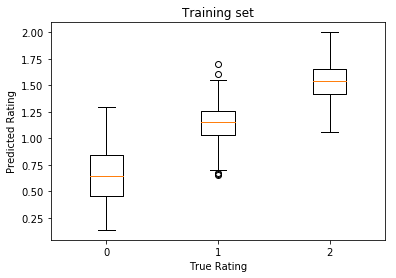

In [69]:
MakeBoxplot(Y_pred, Y, R_train, 'Training set')

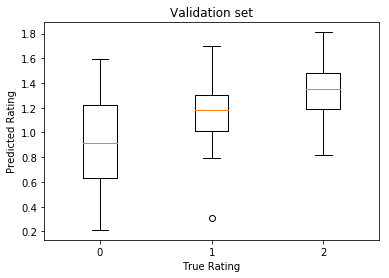

In [70]:
MakeBoxplot(Y_pred, Y, R_valid, 'Validation set')

The performance of Surprise is kind of unstable. It's sometimes better than my models and sometime worse, which is possibly due to how the parameters are initialized.